In [1]:
# Imports
from IPython.display import display

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Prevent infinite warnings
import warnings
warnings.filterwarnings('ignore')

# OS and File imports
import os

this_blue = "#0011DC"
this_orange = "#FF7D00"

In [2]:
root_dir = '..'

br_suicides_data = '/BrSuicides/'

csv_br_suicides_data = os.path.dirname(root_dir + br_suicides_data) + '/'
print(csv_br_suicides_data)

../BrSuicides/


In [3]:
# List all files in the csvs directory
all_files = os.listdir(csv_br_suicides_data)

# Filter for files that end with .zip extension
csv_files = [file for file in all_files if file.endswith('.csv')]
print('CSVs: ', '\n', csv_files)

try:
    # Filter for files that end with .zip extension
    # gets the last one which is supposed to be the most recent
    csv_file_name = csv_files[-1]
    print('CSV file name: ', '\n', csv_file_name)

    # Get region name
    region_name = 'brazil'
    print('Region name: ', '\n', region_name)
except IndexError:
    print('No CSV files end with ".csv".')

CSVs:  
 ['BrSuicides-1996_2022.csv', 'BrSuicides-1996_2023.csv']
CSV file name:  
 BrSuicides-1996_2023.csv
Region name:  
 brazil


In [4]:
df_brazil = pd.read_csv(csv_br_suicides_data + csv_file_name, encoding='utf-8')

print(df_brazil.info(), '\n')
display(df_brazil.head(5))
print(len(df_brazil.index))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283182 entries, 0 to 283181
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ESTADO      283182 non-null  object 
 1   ANO         283182 non-null  int64  
 2   DTOBITO     283182 non-null  object 
 3   NATURAL     238159 non-null  float64
 4   DTNASC      281940 non-null  object 
 5   IDADE       283182 non-null  float64
 6   SEXO        283179 non-null  object 
 7   RACACOR     262091 non-null  object 
 8   ESTCIV      274881 non-null  object 
 9   ESC         242088 non-null  object 
 10  OCUP        231174 non-null  object 
 11  CODMUNRES   283182 non-null  object 
 12  LOCOCOR     282806 non-null  object 
 13  CODMUNOCOR  283182 non-null  object 
 14  CAUSABAS    283182 non-null  object 
 15  ESC2010     143817 non-null  object 
 16  ESCFALAGR1  125736 non-null  object 
dtypes: float64(2), int64(1), object(14)
memory usage: 36.7+ MB
None 



,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
0,PR,1996,1996-10-24,841.0,1963-08-05,33.0,masculino,NaN,Solteiro,Nenhuma,61200.0,Pinhal de São Bento,outros,Pinhal de São Bento,X709,NaN,NaN
1,PR,1996,1996-02-04,152.0,1920-09-21,75.0,masculino,NaN,Casado,Nenhuma,62100.0,Assaí,domicílio,Assaí,X680,NaN,NaN
2,PR,1996,1996-01-17,841.0,1961-08-28,34.0,masculino,NaN,Solteiro,NaN,62100.0,Abatiá,hospital,Abatiá,X680,NaN,NaN
3,PR,1996,1996-02-07,841.0,1977-09-24,18.0,masculino,NaN,Solteiro,Nenhuma,62100.0,Santa Cecília do Pavão,hospital,São Sebastião da Amoreira,X680,NaN,NaN
4,PR,1996,1996-02-09,841.0,1956-08-30,39.0,masculino,NaN,União consensual,NaN,62100.0,Santa Mariana,domicílio,Santa Mariana,X700,NaN,NaN


283182


## Data Aggregation

In [5]:
# Removing SEXO null values
sexo_value_counts = df_brazil["SEXO"].value_counts()
print(sexo_value_counts)
valid_sexo_values = ['masculino', 'feminino']

df_brazil = df_brazil[df_brazil["SEXO"].isin(valid_sexo_values)]

sexo_value_counts = df_brazil["SEXO"].value_counts()
print(sexo_value_counts)

estciv_value_counts = df_brazil["ESTCIV"].value_counts()
print(estciv_value_counts)

SEXO
masculino    223025
feminino      60129
Ignorado         25
Name: count, dtype: int64
SEXO
masculino    223025
feminino      60129
Name: count, dtype: int64
ESTCIV
Solteiro                  141917
Casado                     81791
Separado judicialmente     17664
Ignorado                   12024
Viúvo                      11000
União consensual           10461
Name: count, dtype: int64


In [6]:
# Chosen attributes
chosen_attributes = ["ESTADO", "DTOBITO", "SEXO", "ESTCIV", "CAUSABAS"]

# Keep only chosen attributes
df_brazil = df_brazil[chosen_attributes]

In [7]:
# br_temp to generate brazil time series
br_temp = pd.DataFrame(data=df_brazil)
br_temp['DTOBITO'] = pd.to_datetime(br_temp['DTOBITO'])

br_temp.drop("SEXO", axis=1, inplace=True)

# Get first and last dates to equalize indexes
first_date = br_temp['DTOBITO'].min().strftime("%Y-01-01")
last_date = br_temp['DTOBITO'].max().strftime("%Y-%m-%d")

print(f'first date: {first_date}')
print(f'last date:  {last_date}')

# Date range to make all time series equal
date_range = pd.date_range(start=first_date, end=last_date)

date_range_years = (int(first_date[:4]), int(last_date[:4]))

# Set index to DTOBITO
br_temp.set_index('DTOBITO', inplace=True)

# Prepare br_temp for resampling
br_temp['CAUSABAS'] = 1
br_temp.rename(columns={'CAUSABAS': 'COUNT'}, inplace=True)

# Daily aggregation
ts_brazil_daily = br_temp.resample('D').sum().fillna(0)
ts_brazil_daily['ESTADO'] = 'brazil'

# Monthly aggregation
ts_brazil_monthly = br_temp.resample('M').sum().fillna(0)
ts_brazil_monthly['ESTADO'] = 'brazil'

print("Daily Aggregation:")
print(ts_brazil_daily.head())

print("\nMonthly Aggregation:")
print(ts_brazil_monthly.head())

first date: 1996-01-01
last date:  2023-12-31
Daily Aggregation:
            ESTADO                                             ESTCIV  COUNT
DTOBITO                                                                     
1996-01-01  brazil  CasadoCasadoSolteiroSolteiroSolteiroCasadoCasa...     27
1996-01-02  brazil  Separado judicialmenteSolteiroSolteiroViúvoViú...     22
1996-01-03  brazil  CasadoCasadoCasadoCasadoSolteiroSolteiroCasado...     22
1996-01-04  brazil  SolteiroCasadoUnião consensualSolteiroCasadoCa...     20
1996-01-05  brazil  ViúvoCasadoCasadoSolteiroCasadoSolteiroCasadoV...     15

Monthly Aggregation:
            ESTADO                                             ESTCIV  COUNT
DTOBITO                                                                     
1996-01-31  brazil  CasadoCasadoSolteiroSolteiroSolteiroCasadoCasa...    541
1996-02-29  brazil  CasadoSolteiroSolteiroSolteiroCasadoSolteiroCa...    543
1996-03-31  brazil  SolteiroCasadoCasadoSolteiroViúvoSolteiroCasad

In [8]:
def plot_ts_frequency(ts, frequency, years_range, main_title=None, figsize=(18, 5), font_size=18, location='no Brasil'):
    start_date, end_date = f"{years_range[0]}-01-01", f"{years_range[1]}-12-31"
    ts_data_filtered = ts.loc[start_date:end_date]

    # Plot config
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(ts_data_filtered.index, ts_data_filtered["COUNT"], color=this_blue)

    # Set specific x-ticks and labels, step=2
    years = range(years_range[0], years_range[1] + 1, 2)
    dates = [pd.to_datetime(f'{year}-01-01') for year in years]

    ax.set_xticks(dates)
    ax.set_xticklabels(years, fontsize=16)
    ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=14)
    
    # Title
    plt.title(main_title if main_title else '', fontsize=font_size)

    # Label config
    plt.ylabel('')
    plt.xlabel('')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

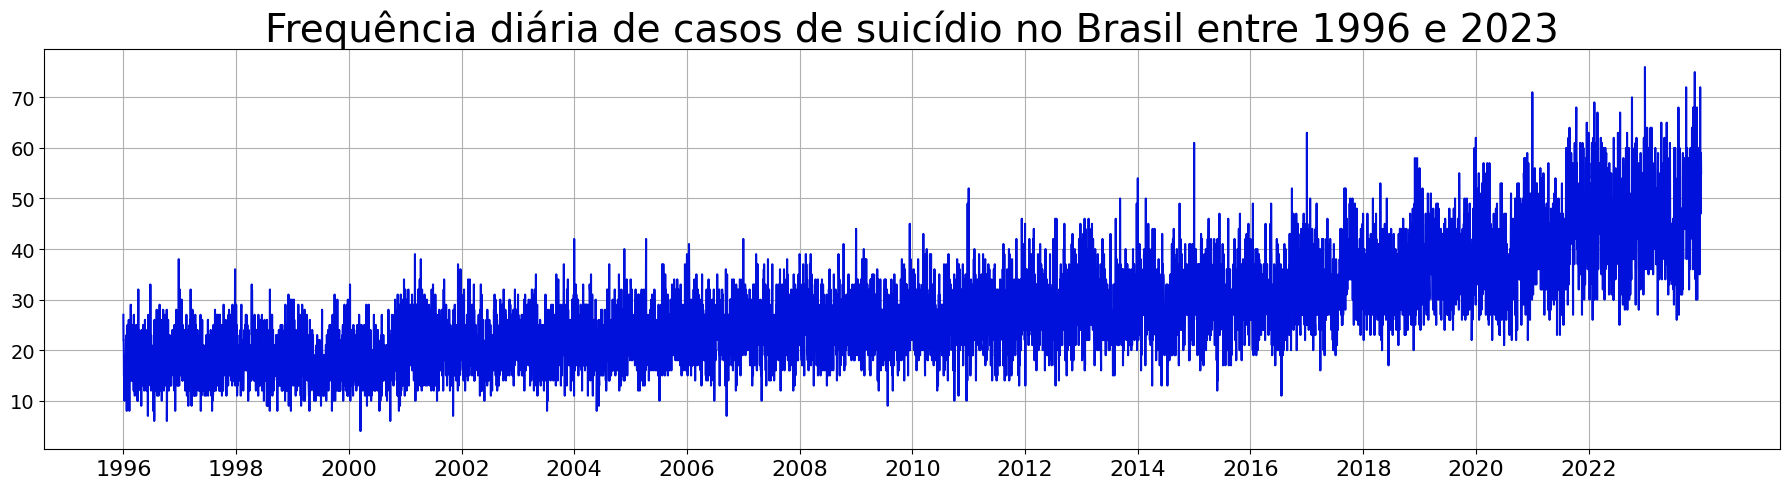

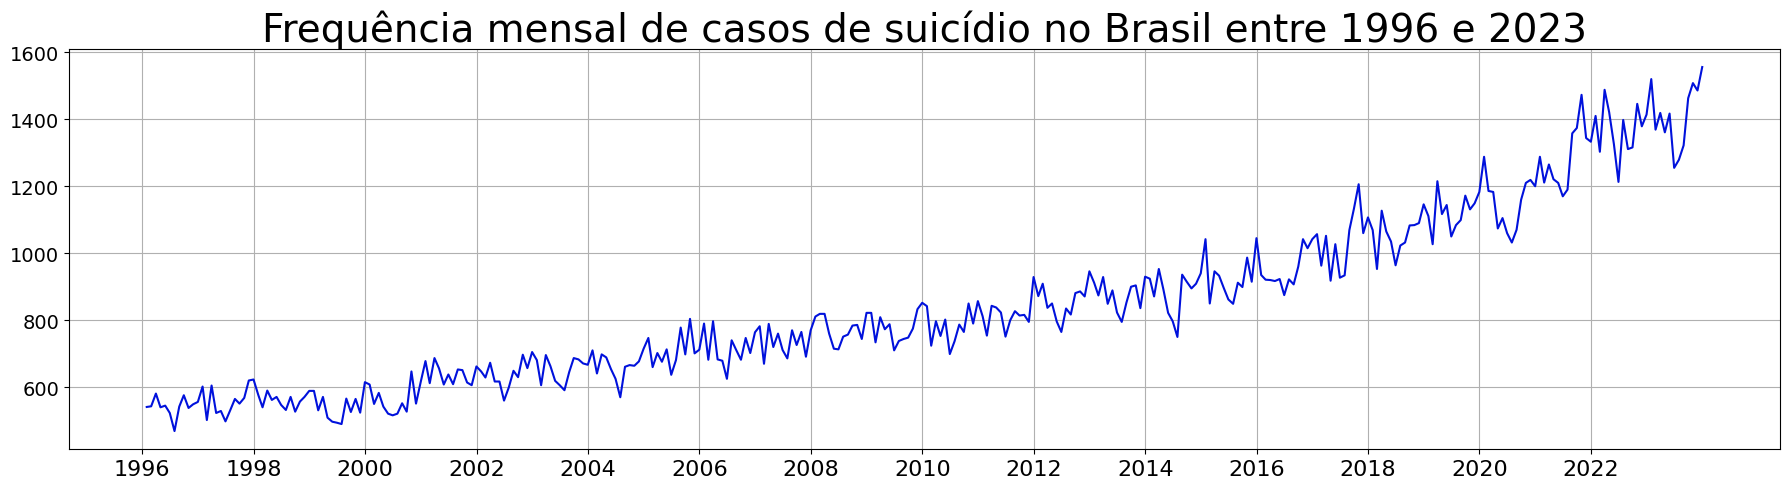

In [9]:
main_title = f'Frequência diária de casos de suicídio no Brasil entre {date_range_years[0]} e {date_range_years[-1]}'
plot_ts_frequency(ts_brazil_daily, 'diária', date_range_years, main_title, font_size=28)

main_title = f'Frequência mensal de casos de suicídio no Brasil entre {date_range_years[0]} e {date_range_years[-1]}'
plot_ts_frequency(ts_brazil_monthly, 'mensal', date_range_years, main_title, font_size=28)

## Attribute and Location filtering

In [10]:
nordeste = ["AL", "BA", "CE", "MA", "PE", "PI", "PB", "RN", "SE"]

In [11]:
# nordeste_temp to generate brazil time series
nordeste_temp = pd.DataFrame(data=df_brazil)
nordeste_temp['DTOBITO'] = pd.to_datetime(nordeste_temp['DTOBITO'])

# Filter for nordeste region
nordeste_temp = nordeste_temp[nordeste_temp['ESTADO'].isin(nordeste)]

# Get first and last dates to equalize indexes
first_date = nordeste_temp['DTOBITO'].min().strftime("%Y-01-01")
last_date = nordeste_temp['DTOBITO'].max().strftime("%Y-%m-%d")

# Date range to make all time series equal
date_range = pd.date_range(start=first_date, end=last_date)
date_range_years = (int(first_date[:4]), int(last_date[:4]))

# Set index to DTOBITO
nordeste_temp.set_index('DTOBITO', inplace=True)

# Get dummy variables from SEXO
estciv_dummies = pd.get_dummies(nordeste_temp['ESTCIV'])
nordeste_temp = pd.concat([nordeste_temp, estciv_dummies], axis=1)
nordeste_temp.drop("ESTCIV", axis=1, inplace=True)

# Get dummy variables from SEXO
sex_dummies = pd.get_dummies(nordeste_temp['SEXO'])
sex_dummies.rename(columns={'masculino': 'M', 'feminino': 'F'}, inplace=True)
nordeste_temp = pd.concat([nordeste_temp, sex_dummies], axis=1)
nordeste_temp.drop("SEXO", axis=1, inplace=True)

# Prepare nordeste_temp for resampling
nordeste_temp['CAUSABAS'] = 1
nordeste_temp.rename(columns={'CAUSABAS': 'COUNT'}, inplace=True)

# Daily aggregation for nordeste
ts_nordeste_daily = nordeste_temp.resample('D').sum().fillna(0)
ts_nordeste_daily['ESTADO'] = 'nordeste'

# Yearly aggregation for nordeste
ts_nordeste_yearly = nordeste_temp.resample('Y').sum().fillna(0)
ts_nordeste_yearly.index = ts_nordeste_yearly.index - pd.offsets.YearEnd() + pd.offsets.YearBegin()
ts_nordeste_yearly['ESTADO'] = 'nordeste'

print("Daily Aggregation for nordeste:")
print(ts_nordeste_daily.head())

print("\nYearly Aggregation for nordeste:")
print(ts_nordeste_yearly.head())

Daily Aggregation for nordeste:
              ESTADO  COUNT  Casado  Ignorado  Separado judicialmente  \
DTOBITO                                                                 
1996-01-01  nordeste      4       1         0                       0   
1996-01-02  nordeste      4       3         0                       0   
1996-01-03  nordeste      4       2         0                       0   
1996-01-04  nordeste      1       1         0                       0   
1996-01-05  nordeste      1       0         0                       0   

            Solteiro  União consensual  Viúvo  F  M  
DTOBITO                                              
1996-01-01         2                 0      0  1  3  
1996-01-02         1                 0      0  1  3  
1996-01-03         2                 0      0  0  4  
1996-01-04         0                 0      0  0  1  
1996-01-05         0                 0      0  0  1  

Yearly Aggregation for nordeste:
              ESTADO  COUNT  Casado  Ignorad

In [12]:
def plot_sex_comparison(ts_dict, years_range, main_title=None, figsize=(18, 5), font_size=18, colors=["#0011DC", "#553593", "#80476E", "#D56B25", "#FF7D00"], line_width=2):
    start_date, end_date = f"{years_range[0]}-01-01", f"{years_range[1]}-12-31"

    # Define different line styles for each series
    line_styles = ['-', '--', ':', '-.', (0, (3, 5, 1, 5))]

    # Plot config
    fig, ax = plt.subplots(figsize=figsize)
    
    for (col_name, data_series), color, style in zip(ts_dict.items(), colors, line_styles):
        data_series_filtered = data_series.loc[start_date:end_date]
        ax.plot(data_series_filtered.index, data_series_filtered, label=col_name, color=color, linestyle=style, linewidth=line_width)

    # Set specific x-ticks and labels, step=2
    years = range(years_range[0], years_range[1] + 1, 2)
    dates = [pd.to_datetime(f'{year}-01-01') for year in years]

    ax.set_xticks(dates)
    ax.set_xticklabels(years, fontsize=16)
    ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=14)
    
    # Title
    plt.title(main_title if main_title else '', fontsize=font_size)

    # Label config
    plt.ylabel('')
    plt.xlabel('')
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()


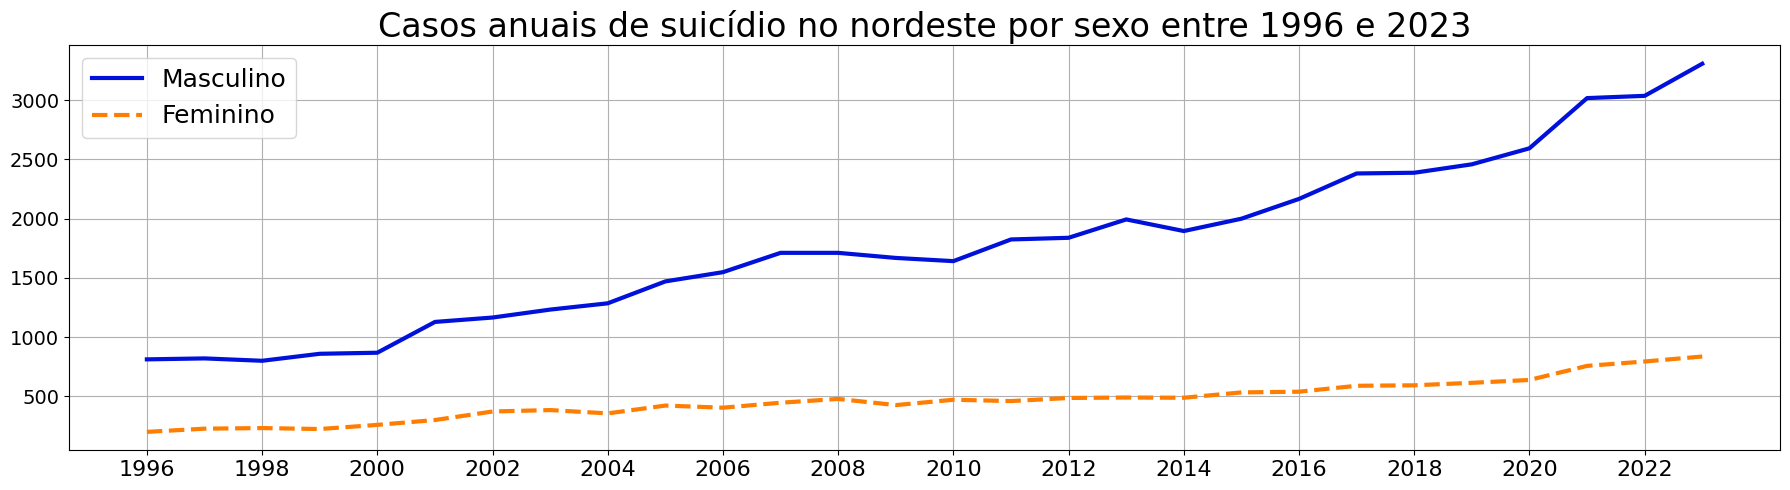

In [13]:
nordeste_sexo_dict = {
    'Masculino': ts_nordeste_yearly['M'],
    'Feminino': ts_nordeste_yearly['F']
}

main_title = f'Casos anuais de suicídio no nordeste por sexo entre {date_range_years[0]} e {date_range_years[-1]}'
plot_sex_comparison(nordeste_sexo_dict, date_range_years, main_title, font_size=24, colors=["#0011DC", "#FF7D00"], line_width=3)

In [14]:
casado = 'Casado'
separado = 'Separado judicialmente'
solteiro = 'Solteiro'
viuvo = 'Viúvo'
ignorado = 'Ignorado'

nordeste_estciv_dict = {
    casado: ts_nordeste_yearly[casado],
    separado: ts_nordeste_yearly[separado],
    solteiro: ts_nordeste_yearly[solteiro],
    viuvo: ts_nordeste_yearly[viuvo],
    ignorado: ts_nordeste_yearly[ignorado],
}

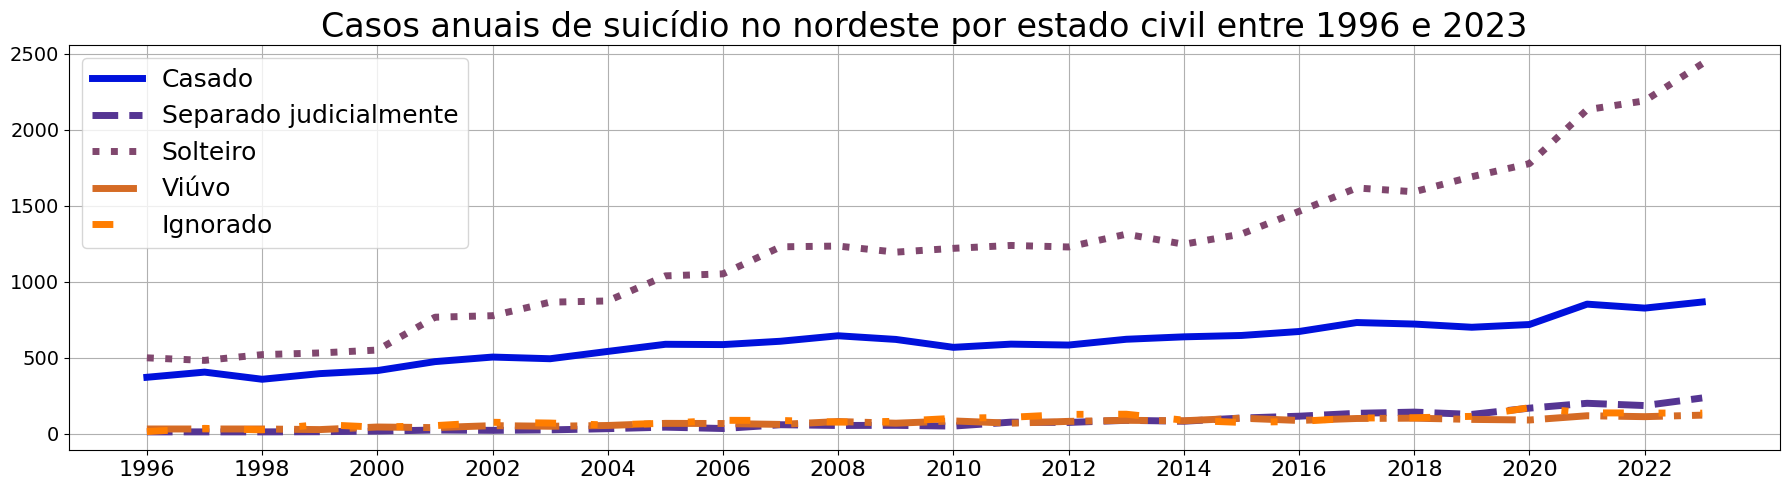

In [15]:
main_title = f'Casos anuais de suicídio no nordeste por estado civil entre {date_range_years[0]} e {date_range_years[-1]}'
plot_sex_comparison(nordeste_estciv_dict, date_range_years, main_title, font_size=24, line_width=5)

## Decomposition

In [16]:
# sudeste states list
sudeste = ["ES", "MG", "RJ", "SP"]

In [17]:
# sudeste_temp to generate brazil time series
sudeste_temp = pd.DataFrame(data=df_brazil)
sudeste_temp['DTOBITO'] = pd.to_datetime(sudeste_temp['DTOBITO'])

sudeste_temp.drop("SEXO", axis=1, inplace=True)

# Filter for Sudeste region
sudeste_temp = sudeste_temp[sudeste_temp['ESTADO'].isin(sudeste)]

# Get first and last dates to equalize indexes
first_date = sudeste_temp['DTOBITO'].min().strftime("%Y-01-01")
last_date = sudeste_temp['DTOBITO'].max().strftime("%Y-%m-%d")

# Date range to make all time series equal
date_range = pd.date_range(start=first_date, end=last_date)
date_range_years = (int(first_date[:4]), int(last_date[:4]))

# Set index to DTOBITO
sudeste_temp.set_index('DTOBITO', inplace=True)

# Prepare sudeste_temp for resampling
sudeste_temp['CAUSABAS'] = 1
sudeste_temp.rename(columns={'CAUSABAS': 'COUNT'}, inplace=True)

# Monthly aggregation for Sudeste
ts_sudeste_monthly = sudeste_temp.resample('M').sum().fillna(0)
ts_sudeste_monthly['ESTADO'] = 'sudeste'

# Yearly aggregation for nordeste
ts_sudeste_yearly = sudeste_temp.resample('Y').sum().fillna(0)
ts_sudeste_yearly.index = ts_sudeste_yearly.index - pd.offsets.YearEnd() + pd.offsets.YearBegin()
ts_sudeste_yearly['ESTADO'] = 'sudeste'

print("\Monthly Aggregation for Sudeste:")
print(ts_sudeste_monthly.head())

print("\nYearly Aggregation for nordeste:")
print(ts_sudeste_yearly.head())

\Monthly Aggregation for Sudeste:
             ESTADO                                             ESTCIV  COUNT
DTOBITO                                                                      
1996-01-31  sudeste  SolteiroCasadoSolteiroCasadoSolteiroSeparado j...    236
1996-02-29  sudeste  SolteiroCasadoSolteiroSeparado judicialmenteCa...    214
1996-03-31  sudeste  SolteiroSolteiroCasadoSolteiroCasadoSeparado j...    223
1996-04-30  sudeste  SolteiroSolteiroCasadoCasadoSolteiroViúvoSolte...    220
1996-05-31  sudeste  SolteiroSolteiroSolteiroCasadoSolteiroSolteiro...    211

Yearly Aggregation for nordeste:
             ESTADO                                             ESTCIV  COUNT
DTOBITO                                                                      
1996-01-01  sudeste  SolteiroCasadoSolteiroCasadoSolteiroSeparado j...   2647
1997-01-01  sudeste  SolteiroCasadoSolteiroCasadoSolteiroSolteiroSe...   2779
1998-01-01  sudeste  SolteiroSolteiroSolteiroSolteiroCasadoSolteiro...   2

In [18]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore

def generate_poisson_trend_and_plot(ts, years_range, main_title=None, col_name="COUNT", figsize=(20, 5), font_size=18):
    start_date, end_date = f"{years_range[0]}-01-01", f"{years_range[1]}-12-31"

    # Set specific x-ticks and labels, step=2
    years = range(years_range[0], years_range[1] + 1, 2)
    dates = [pd.to_datetime(f'{year}-01-01') for year in years]
    
    # Create a time index
    time_index = (ts.index - ts.index[0]).days  # Convert datetime to numerical index
    
    # Fit a Poisson regression model
    poisson_model = sm.GLM(ts[col_name], sm.add_constant(time_index), family=sm.families.Poisson()).fit()
    
    # Generate trend values
    trend = poisson_model.predict(sm.add_constant(time_index))
    
    # Create a DataFrame for the trend with the same datetime index
    trend_df = pd.Series(trend, index=ts.index)
    
    # Plot the trend
    plt.figure(figsize=figsize)
    plt.plot(ts.index, ts[col_name], label='Dados observados', color=this_orange)
    plt.plot(ts.index, trend_df, label='Tendência extraída', color=this_blue)
    plt.legend(fontsize=18)
    plt.xticks(dates, [date.year for date in dates], fontsize=16)
    plt.yticks(fontsize=14)
    plt.title(main_title if main_title else '', fontsize=font_size)
    plt.grid(True)
    plt.show()

def generate_seasonality_and_plot(ts, years_range, main_title=None, col_name="COUNT", figsize=(20, 5), font_size=18):
    start_date, end_date = f"{years_range[0]}-01-01", f"{years_range[1]}-12-31"

    # Set specific x-ticks and labels, step=2
    years = range(years_range[0], years_range[1] + 1, 2)
    dates = [pd.to_datetime(f'{year}-01-01') for year in years]
    
    # Z-normalize the time series
    ts_z = ts.copy()
    ts_z[col_name] = zscore(ts[col_name])

    # Perform STL decomposition
    stl = STL(ts_z[col_name], seasonal=13)
    result = stl.fit()
    
    # Extract the seasonal component
    seasonality = result.seasonal
    
    # Plot the seasonal component
    plt.figure(figsize=figsize)
    plt.plot(ts.index, seasonality, label='Componente de sazonalidade', color='green')
    plt.legend(fontsize=18)
    plt.xticks(dates, [date.year for date in dates], fontsize=16)
    plt.yticks(fontsize=14)
    plt.title(main_title if main_title else '', fontsize=font_size)
    plt.grid(True)
    plt.show()

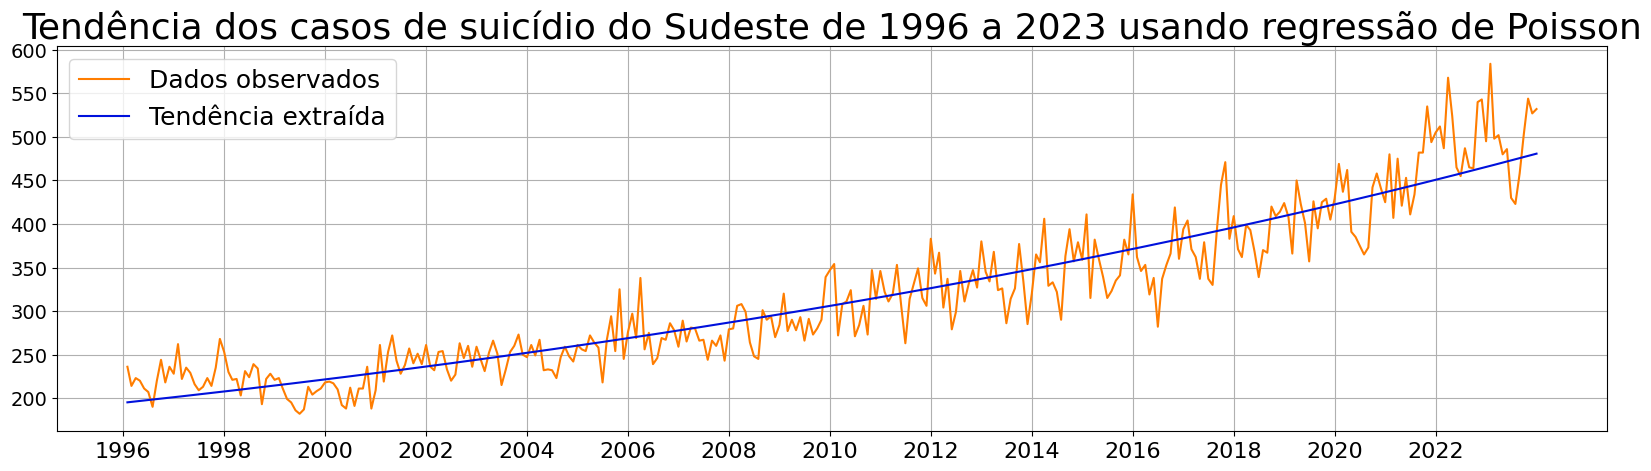

In [19]:
main_title = f'Tendência dos casos de suicídio do Sudeste de {date_range_years[0]} a {date_range_years[-1]} usando regressão de Poisson'
generate_poisson_trend_and_plot(ts_sudeste_monthly, date_range_years, main_title, 'COUNT', font_size=26)

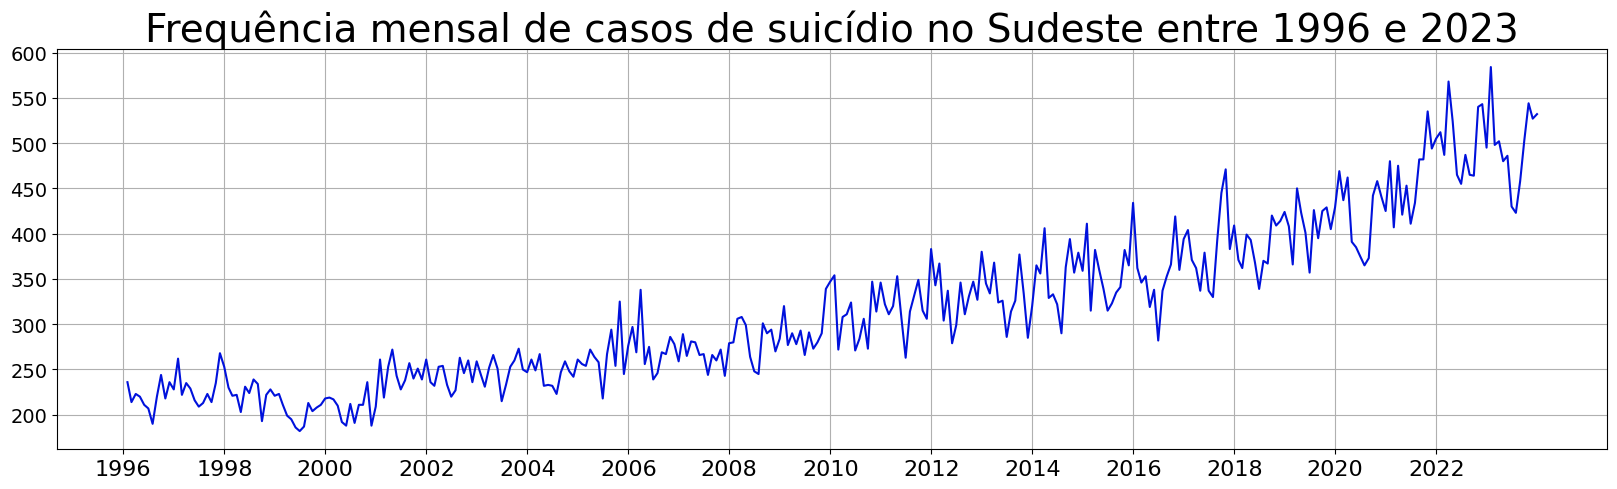

In [20]:
main_title = f'Frequência mensal de casos de suicídio no Sudeste entre {date_range_years[0]} e {date_range_years[-1]}'
plot_ts_frequency(ts_sudeste_monthly, 'mensal', date_range_years, main_title, (16.275,5), font_size=28)

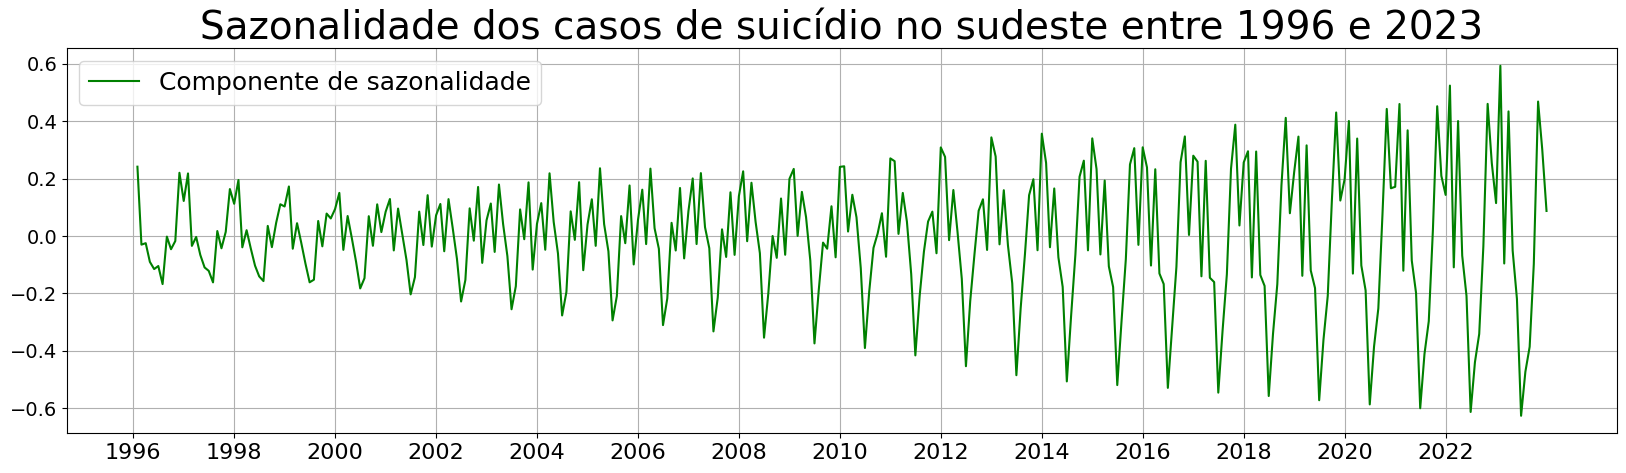

In [21]:
main_title = f'Sazonalidade dos casos de suicídio no sudeste entre {date_range_years[0]} e {date_range_years[-1]}'
generate_seasonality_and_plot(ts_sudeste_monthly, date_range_years, main_title, "COUNT", font_size=28)

## Similarity Comparison

In [22]:
sul_tss = {
    "PR": pd.DataFrame(),
    "SC": pd.DataFrame(),
    "RS": pd.DataFrame(),
}

# Sul states list
sul = ["PR", "SC", "RS"]

# br_temp to generate brazil time series
br_temp = pd.DataFrame(data=df_brazil)
br_temp['DTOBITO'] = pd.to_datetime(br_temp['DTOBITO'])

br_temp.drop("SEXO", axis=1, inplace=True)

# Get first and last dates to equalize indexes
first_date = br_temp['DTOBITO'].min().strftime("%Y-01-01")
last_date = br_temp['DTOBITO'].max().strftime("%Y-%m-%d")

# Date range to make all time series equal
date_range = pd.date_range(start=first_date, end=last_date)

date_range_years = (int(first_date[:4]), int(last_date[:4]))

# Set index to DTOBITO
br_temp.set_index('DTOBITO', inplace=True)

# Prepare br_temp for resampling
br_temp['CAUSABAS'] = 1
br_temp.rename(columns={'CAUSABAS': 'COUNT'}, inplace=True)

# Generate time series for each state in sul
for state in sul:
    state_temp = br_temp[br_temp['ESTADO'] == state].copy()
    state_temp = state_temp.resample('M').sum().fillna(0)
    sul_tss[state] = state_temp
    sul_tss[state]['ESTADO'] = state
    print(f"\nMonthly Aggregation for {state}:")
    print(state_temp.head())

# Generate combined time series for sul
ts_sul_monthly = pd.DataFrame(columns=["ESTADO", "COUNT"])
ts_sul_monthly['COUNT'] = sum(sul_tss[state]["COUNT"] for state in sul)
ts_sul_monthly['ESTADO'] = 'sul'
sul_tss['SUL'] = ts_sul_monthly

print("\nMonthly Aggregation for Sul (combined):")
print(ts_sul_monthly.head())


Monthly Aggregation for PR:
           ESTADO                                             ESTCIV  COUNT
DTOBITO                                                                    
1996-01-31     PR  CasadoCasadoSolteiroSolteiroSeparado judicialm...     55
1996-02-29     PR  SolteiroCasadoSolteiroCasadoCasadoCasadoSoltei...     57
1996-03-31     PR  SolteiroSolteiroCasadoCasadoCasadoSolteiroSepa...     59
1996-04-30     PR  SolteiroCasadoSolteiroSolteiroCasadoSolteiroSo...     50
1996-05-31     PR  Separado judicialmenteCasadoCasadoSolteiroCasa...     43

Monthly Aggregation for SC:
           ESTADO                                             ESTCIV  COUNT
DTOBITO                                                                    
1996-01-31     SC  CasadoCasadoUnião consensualSolteiroCasadoCasa...     31
1996-02-29     SC  CasadoSolteiroSolteiroSolteiroSolteiroCasadoSo...     27
1996-03-31     SC  CasadoCasadoCasadoSolteiroSeparado judicialmen...     47
1996-04-30     SC  CasadoCasad

In [23]:
def plot_comparison(ts1, ts2, ts1_name, ts2_name, years_range, main_title=None, column="COUNT", figsize=(18, 5), font_size=18):
    start_date, end_date = f"{years_range[0]}-01-01", f"{years_range[1]}-12-31"

    # Set specific x-ticks and labels, step=2
    years = range(years_range[0], years_range[1] + 1, 2)
    dates = [pd.to_datetime(f'{year}-01-01') for year in years]
    
    # Calculate the distance (difference) between the two time series
    ts1_values = zscore(ts1[column])
    ts2_values = zscore(ts2[column])
    distance = ts1_values - ts2_values

    # Plot the two time series
    plt.figure(figsize=figsize)
    plt.plot(ts1_values, label=f"{ts1_name}", color=this_blue, alpha=0.666)
    plt.plot(ts2_values, label=f"{ts2_name}", color=this_orange)
    
    plt.xticks(dates, [date.year for date in dates], fontsize=16)
    plt.yticks(fontsize=14)
    
    plt.title(main_title if main_title else '', fontsize=font_size)
    plt.xlabel('')
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

    # Plot the distance (difference) between the two time series
    plt.figure(figsize=figsize)
    plt.plot(distance, label="", color="green")
    
    # Set specific x-ticks and labels
    plt.xticks(dates, [date.year for date in dates], fontsize=16)
    plt.yticks(fontsize=14)
    
    plt.title('Distância entre as séries temporais comparadas', fontsize=font_size)
    plt.xlabel('')
    plt.grid(True)
    plt.legend('', fontsize=16)
    plt.show()

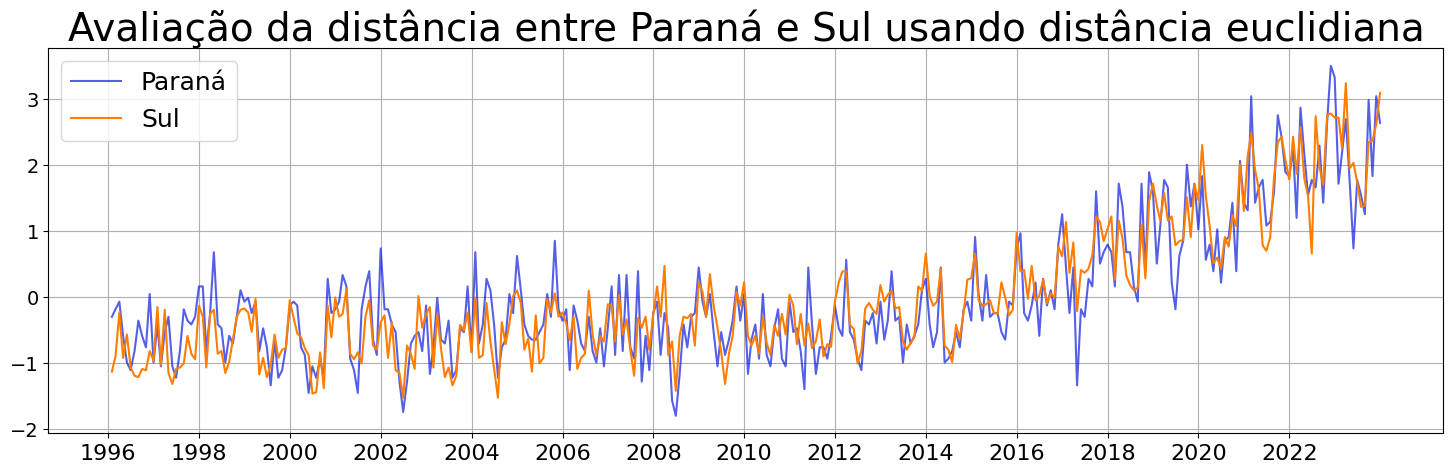

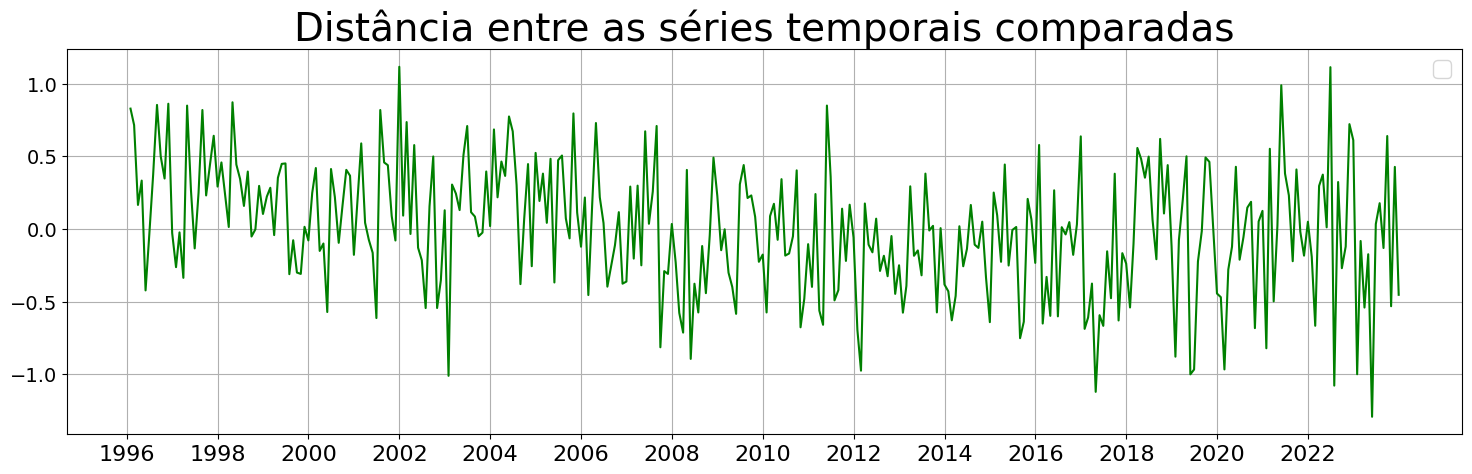

In [24]:
plot_title = 'Avaliação da distância entre Paraná e Sul usando distância euclidiana'
plot_comparison(sul_tss['PR'], ts_sul_monthly, ts1_name="Paraná", ts2_name="Sul", years_range=date_range_years, main_title=plot_title, column="COUNT", font_size=28)

In [25]:
# plot_comparison(sul_tss['PR'], sul_tss['SC'], ts1_name="Paraná", ts2_name="Santa Catarina", years_range=date_range_years, column="COUNT")

In [26]:
# plot_comparison(sul_tss['PR'], sul_tss['RS'], ts1_name="Paraná", ts2_name="Rio Grande do Sul", years_range=date_range_years, column="COUNT")